In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, roc_auc_score, precision_recall_curve)
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# Set aesthetic parameters
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)

In [8]:
df = pd.read_csv("dataset/synthetic_fraud_dataset.csv")

# Display basic info
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nClass distribution:")
print(df['Fraud_Label'].value_counts(normalize=True))

Dataset shape: (50000, 21)

First 5 rows:


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1



Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d   

In [9]:
# Drop unnecessary IDs
df.drop(['Transaction_ID', 'User_ID'], axis=1, inplace=True)

# Convert timestamp to datetime and extract features
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month
df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(int)
df.drop('Timestamp', axis=1, inplace=True)

# Create new features
df['Transaction_Amount_to_Balance'] = df['Transaction_Amount'] / (df['Account_Balance'] + 1)
df['Transaction_Frequency_Ratio'] = df['Daily_Transaction_Count'] / (df['Avg_Transaction_Amount_7d'] + 1)
df['Failed_Transaction_Rate'] = df['Failed_Transaction_Count_7d'] / (df['Daily_Transaction_Count'] + 1)
df['Risk_History_Ratio'] = df['Previous_Fraudulent_Activity'] / (df['Card_Age'] + 1)

# Drop redundant features
df.drop(['Daily_Transaction_Count', 'Avg_Transaction_Amount_7d', 
         'Failed_Transaction_Count_7d', 'Previous_Fraudulent_Activity'], axis=1, inplace=True)

df.head()


,Transaction_Amount,Transaction_Type,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Card_Type,Card_Age,Transaction_Distance,...,Risk_Score,Is_Weekend,Fraud_Label,Hour,DayOfWeek,Month,Transaction_Amount_to_Balance,Transaction_Frequency_Ratio,Failed_Transaction_Rate,Risk_History_Ratio
0,39.79,POS,93213.17,Laptop,Sydney,Travel,0,Amex,65,883.17,...,0.8494,0,0,19,0,8,0.000427,0.015959,0.375000,0.000000
1,1.19,Bank Transfer,75725.25,Mobile,New York,Clothing,0,Mastercard,186,2203.36,...,0.0959,0,1,4,2,6,0.000016,0.027097,0.285714,0.000000
2,28.96,Online,1588.96,Tablet,Mumbai,Restaurants,0,Visa,226,1909.29,...,0.8400,0,1,15,1,6,0.018214,0.274456,0.266667,0.000000
3,254.32,ATM Withdrawal,76807.20,Tablet,New York,Clothing,0,Visa,76,1311.86,...,0.7935,0,1,0,3,12,0.003311,0.043601,0.444444,0.000000
4,31.28,POS,92354.66,Mobile,Mumbai,Electronics,0,Mastercard,140,966.98,...,0.3819,1,1,23,5,11,0.000339,0.042464,0.266667,0.007092


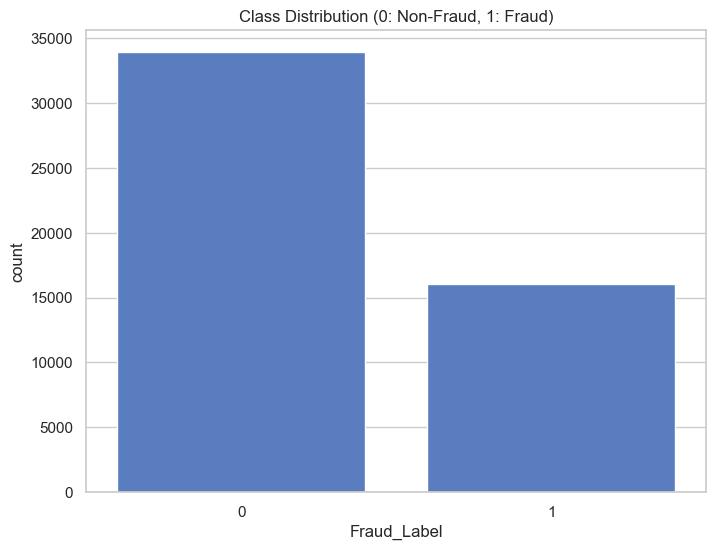

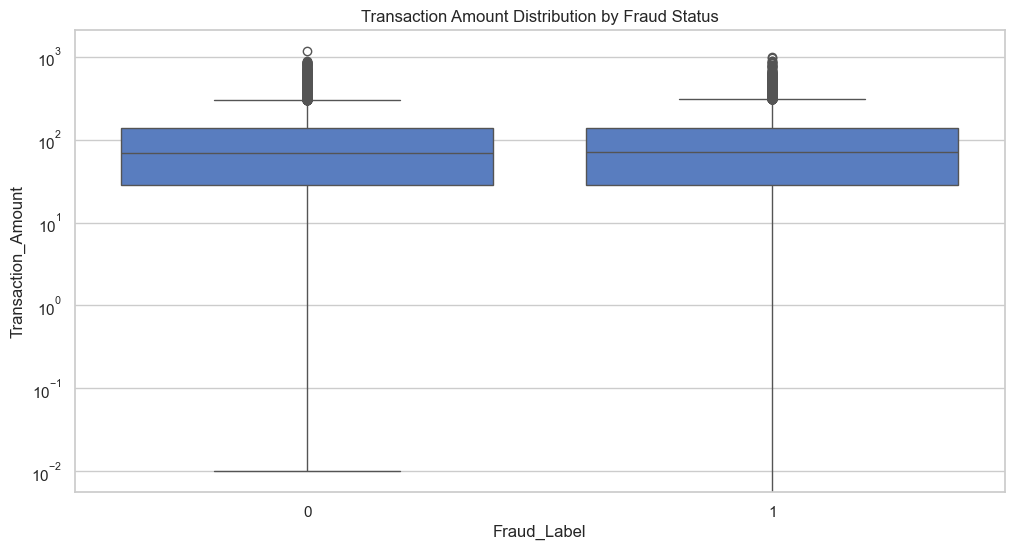

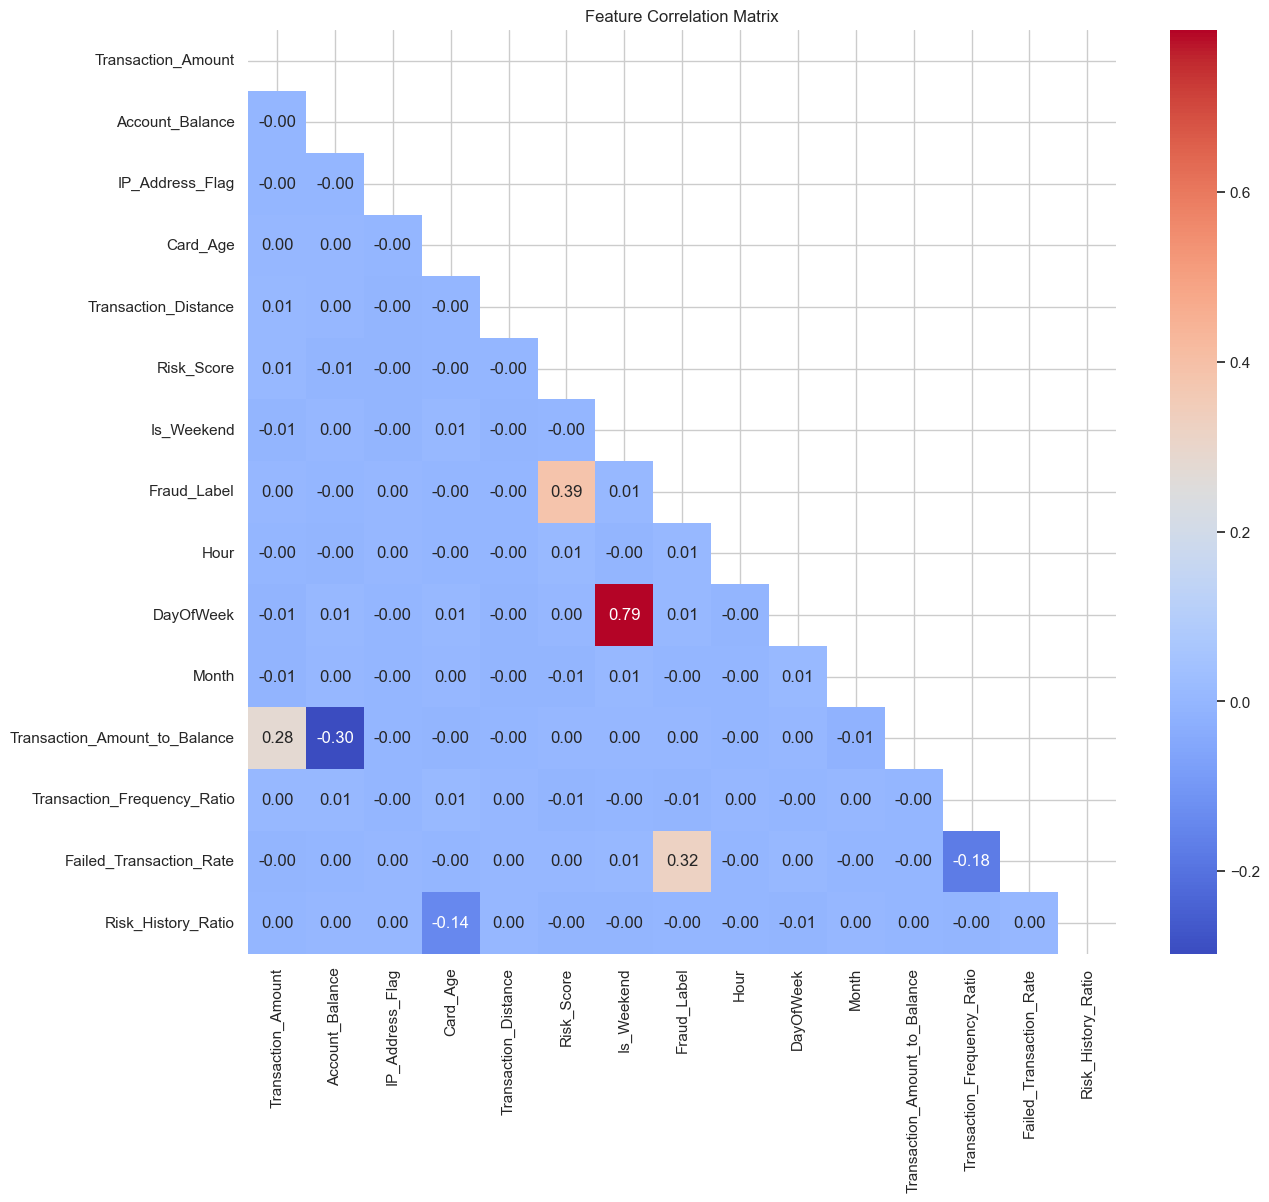

In [10]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Fraud_Label', data=df)
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)')
plt.show()

# Plot transaction amount by fraud status
plt.figure(figsize=(12, 6))
sns.boxplot(x='Fraud_Label', y='Transaction_Amount', data=df)
plt.title('Transaction Amount Distribution by Fraud Status')
plt.yscale('log')  # Log scale for better visualization
plt.show()

# Correlation heatmap
plt.figure(figsize=(14, 12))
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', 
            mask=np.triu(np.ones_like(corr, dtype=bool)))
plt.title('Feature Correlation Matrix')
plt.show()

In [19]:
# Handle categorical variables
cat_cols = ['Transaction_Type', 'Device_Type', 'Location', 
            'Merchant_Category', 'Card_Type', 'Authentication_Method']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Split features and target
X = df.drop('Fraud_Label', axis=1)
y = df['Fraud_Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance with Random Undersampling
rus = RandomUnderSampler(random_state=0)  # 1.0 means equalize both classes
X_res, y_res = rus.fit_resample(X_train_scaled, y_train)

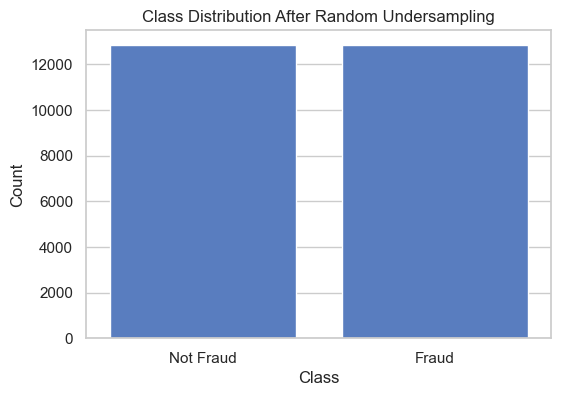

In [20]:
# Plot class distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_res)
plt.title('Class Distribution After Random Undersampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()

Logistic Regression Performance:
Accuracy: 0.7528
ROC AUC: 0.8137

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      6787
           1       0.59      0.78      0.67      3213

    accuracy                           0.75     10000
   macro avg       0.73      0.76      0.74     10000
weighted avg       0.78      0.75      0.76     10000



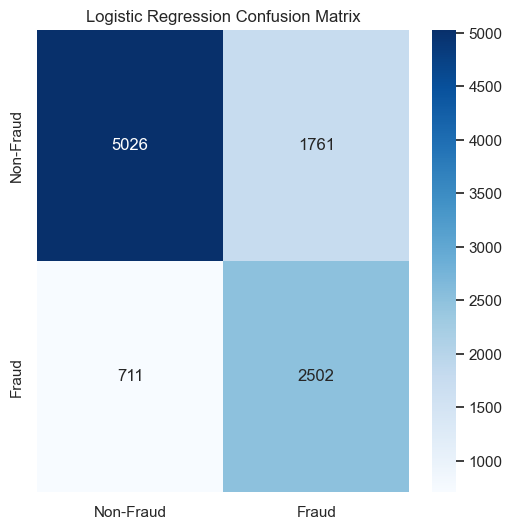

In [27]:
# Initialize and train Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_res, y_res)

# Predictions
y_pred_logreg = logreg.predict(X_test_scaled)
y_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_logreg):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))

# Confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_logreg),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Logistic Regression Confusion Matrix')
plt.show()